# Test DECiSION

## Import packages

In [1]:
import DECiSION_settings as settings
from thesis_common import read_images, read_groundtruths,\
    convert_img_to_pred, convert_pred_to_img, group_images, show_image, create_hdf5_db

from dltoolkit.utils.generic import list_images
from dltoolkit.nn.segment import UNet_NN
from dltoolkit.utils.visual import plot_roc_curve, plot_precision_recall_curve,\
    print_confusion_matrix, print_classification_report

import os, cv2
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

/Users/geoff/anaconda3/envs/ML3-DL-OPENCV/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Path to the model to load

In [2]:
# TRAINED_MODEL_NAME = "../savedmodels/DECiSION_UNet_brain_softmax_ep100-VERY_GREAT-loss391.65658.model"
TRAINED_MODEL_NAME = "../savedmodels/DECiSION_UNet_brain_3layer_BN_ep100.model"

## Convert test data to HDF5

In [3]:
def perform_hdf5_conversion_test(settings):
    # Prepare the path to the TEST images AND ground truths
    img_exts = ".jpg"
    img_path = os.path.join(settings.TEST_PATH, settings.FLDR_IMAGES)
    msk_path = os.path.join(settings.TEST_PATH, settings.FLDR_GROUND_TRUTH)

    # Create a list of paths to the individual patient folders
    patient_fld_imgs = sorted([os.path.join(img_path, e.name) for e in os.scandir(img_path) if e.is_dir()])
    patient_fld_masks = sorted([os.path.join(msk_path, e.name) for e in os.scandir(msk_path) if e.is_dir()])

    # Obtain a list of paths to the test images and ground truths for each patient
    img_list = []
    msk_list = []
    for patient_ix, (p_fld_imgs, p_fld_masks) in enumerate(zip(patient_fld_imgs, patient_fld_masks)):
        img_list.extend(sorted(list(list_images(basePath=p_fld_imgs,
                                                validExts=img_exts)))
                        [settings.SLICE_START:settings.SLICE_END])
        msk_list.extend(sorted(list(list_images(basePath=p_fld_masks,
                                                validExts=img_exts)))
                        [settings.SLICE_START:settings.SLICE_END])

    assert(len(img_list) == len(msk_list))

    # Create the HDF5 data sets
    output_paths = []

    # Test images
    output_paths.append(create_hdf5_db(img_list, "test", img_path,
                                       (settings.IMG_HEIGHT, settings.IMG_WIDTH, settings.IMG_CHANNELS),
                                       key=settings.HDF5_KEY, ext=settings.HDF5_EXT, settings=settings))

    # Test ground truths
    output_paths.append(create_hdf5_db(msk_list, "test", msk_path,
                                       (settings.IMG_HEIGHT, settings.IMG_WIDTH, settings.IMG_CHANNELS),
                                       key=settings.HDF5_KEY, ext=settings.HDF5_EXT, settings=settings,
                                       is_mask=True))
    
    return output_paths

def perform_hdf5_conversion_inference(settings):
    # Prepare the path to the TEST images (and NO ground truths)
    img_exts = ".jpg"
    test_path = os.path.join(settings.TEST_PATH, settings.FLDR_IMAGES)

    # Create a list of paths to the individual patient folders
    test_imgs = sorted(list(list_images(basePath=test_path, validExts=img_exts)))[settings.SLICE_START:settings.SLICE_END]

    # Create the HDF5 data sets
    output_paths = []

    # Test images (no ground truths available, no need to split). The assumption is only
    # relevant images are placed in the test folder, i.e. the pipeline will not exclude
    # any slices
    output_paths.append(create_hdf5_db(test_imgs, "test", test_path,
                                        (settings.IMG_HEIGHT, settings.IMG_WIDTH, settings.IMG_CHANNELS),
                                        key=settings.HDF5_KEY, ext=settings.HDF5_EXT, settings=settings))

    return output_paths

if settings.IS_DEVELOPMENT and settings.IS_MODEL_EVALUATION:
    output_paths = perform_hdf5_conversion_test(settings)
elif not settings.IS_DEVELOPMENT:
    output_paths = perform_hdf5_conversion_inference(settings)

## Load data

In [4]:
# Load the images and ground truths
if settings.IS_DEVELOPMENT:
    if settings.IS_MODEL_EVALUATION:
        # Use test images WITH ground truths for final model evaluation
        print("WARNING: using TEST images, NOT TRAINING images for MODEL SELECTION")
        test_imgs = read_images(output_paths[0], settings.HDF5_KEY)
        test_ground_truths = read_groundtruths(output_paths[1], settings.HDF5_KEY)
    else:
        # Use training images for pipeline validation and training
        print("WARNING: using TRAINING images, NOT TEST images for PIPELINE DEVELOPMENT")
        test_imgs = read_images("../data/MSC8002/training/train_images.h5", settings.HDF5_KEY)
        test_ground_truths = read_groundtruths("../data/MSC8002/training/train_groundtruths.h5", settings.HDF5_KEY)
else:
    print("--- Pre-processing test images without ground truths for inference")
    # Use for inference on test images without ground truths
    test_imgs = read_images(output_paths[0], settings.HDF5_KEY)

Loading image HDF5: ../data/MSC8002/training/train_images.h5 with dtype = float16
Loading ground truth HDF5: ../data/MSC8002/training/train_groundtruths.h5 with dtype = uint8


## Show one image to check

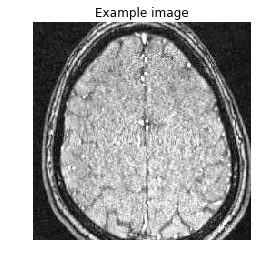

       Max image intensity: 1.0 - float16 - (27, 240, 240, 1)


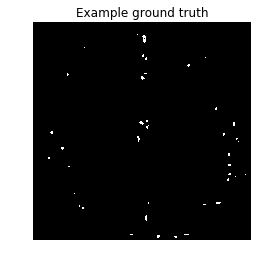

Max ground truth intensity: 255 - uint8 - (27, 240, 240, 1)


In [5]:
# Show an image plus its ground truth to check
IX = 0
show_image(np.squeeze(test_imgs[IX]), 'Example image')

print("       Max image intensity: {} - {} - {}".format(np.max(test_imgs[IX]), test_imgs.dtype, test_imgs.shape))
if settings.IS_DEVELOPMENT:
    show_image(np.squeeze(test_ground_truths[IX]), 'Example ground truth')
    print("Max ground truth intensity: {} - {} - {}".format(np.max(test_ground_truths[IX]), test_ground_truths.dtype, test_ground_truths.shape))

## Load the trained model

In [6]:
# Create the UNet model and load its saved weights
unet = UNet_NN(img_height=settings.IMG_HEIGHT,
               img_width=settings.IMG_WIDTH,
               img_channels=settings.IMG_CHANNELS,
               num_classes=settings.NUM_CLASSES)
model = unet.build_model_BRAIN(use_bn=True, use_dropout=False)
model.load_weights(TRAINED_MODEL_NAME)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 240, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 240, 240, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 240, 240, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 240, 240, 32) 9248        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

## Make predictions

In [7]:
predictions = model.predict(test_imgs, batch_size=settings.TRN_BATCH_SIZE, verbose=2)

## Convert predictions to segmentation map images

In [8]:
predictions_imgs = convert_pred_to_img(predictions,
                                       threshold=settings.TRN_PRED_THRESHOLD,
                                       verbose=settings.VERBOSE)
print("Predictions shape: {}".format(predictions.shape))

Elapsed time: 0.14632892608642578
Predictions shape: (27, 240, 240, 2)


## Show segmentation maps

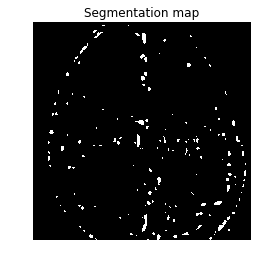

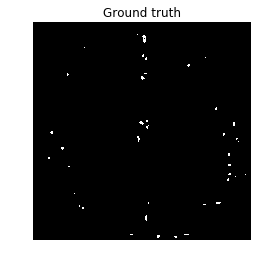

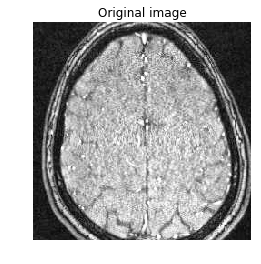

  original 1.0 dtype float16
  gr truth 255 dtype uint8
prediction 255 dtype uint8


In [9]:
MAX_IMAGES = 10
if settings.IS_DEVELOPMENT:
    # Show a single image, ground truth and segmentation map
    show_image(np.squeeze(predictions_imgs[0]), 'Segmentation map')
    show_image(np.squeeze(test_ground_truths[0]), 'Ground truth')
    show_image(np.squeeze(test_imgs[0]), 'Original image')

    # Plot a number of ground truths in a single image 
    group_images(test_ground_truths[0:min(16, MAX_IMAGES)], 4, 1.0, False, "../output/DECISION_"+unet.title+"_grp_originals")

# Plot images and segmentation maps in a single images
group_images(test_imgs[0:min(16, MAX_IMAGES)], 4, 1.0, False, "../output/DECISION_" + unet.title+"_grp_images")
group_images(predictions_imgs[0:min(16, MAX_IMAGES)], 4, 1.0, False, "../output/DECISION_" + unet.title+"_grp_predictions")

print("  original {} dtype {}".format(np.max(test_imgs[0]), test_imgs[0].dtype))
print("  gr truth {} dtype {}".format(np.max(test_ground_truths[0]), test_ground_truths[0].dtype))
print("prediction {} dtype {}".format(np.max(predictions_imgs[0]), predictions_imgs[0].dtype))

## Show metrics

### ROC curve

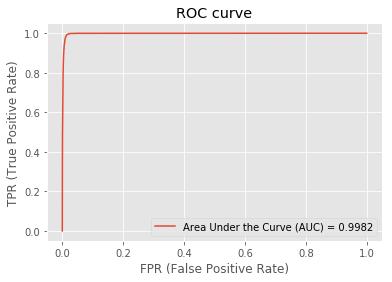

In [10]:
if settings.IS_DEVELOPMENT:
    roc_path = os.path.join(settings.OUTPUT_PATH, "DECiSION_" + unet.title)
    plot_roc_curve(test_ground_truths, predictions[:,:,:,1], show=True, save_path=roc_path)

### Precision/recall curve


Area under Precision-Recall curve: 0.7361263148656144


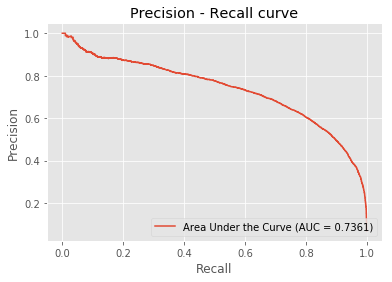

In [11]:
if settings.IS_DEVELOPMENT:
    prec_path = os.path.join(settings.OUTPUT_PATH, "DECiSION_" + unet.title)
    plot_precision_recall_curve(test_ground_truths, predictions, settings.NUM_CLASSES, show=True, save_path=prec_path)

### Confusion matrix

In [12]:
if settings.IS_DEVELOPMENT:
    (conf_ind, conf_mat) = print_confusion_matrix(test_ground_truths, predictions_imgs)

Confusion matrix:
[[1517385   29873]
 [     35    7907]]
   Row/Column: Negative Class, Positive Class, i.e.:
             TN FP
             FN TP

 True Negative (TN): 1517385
 True Positive (TP): 7907
False Negative (FN): 35
False Positive (FP): 29873

Blood vessel precision: 0.21
   Blood vessel recall: 1.00


### Classification report

In [13]:
if settings.IS_DEVELOPMENT:
    print_classification_report(test_ground_truths, predictions_imgs)

Precision: 0.21
   Recall: 1.00
             precision    recall  f1-score   support

 background       1.00      0.98      0.99   1547258
     vessel       0.21      1.00      0.35      7942

avg / total       1.00      0.98      0.99   1555200



## Write segmentation maps, ground truths and originals

In [14]:
for i in range(len(predictions_imgs)):
    cv2.imwrite("../output/segmentation_maps/segmap_{}.png".format(i), predictions_imgs[i])

In [15]:
for i in range(len(test_ground_truths)):
    cv2.imwrite("../output/segmentation_maps/groundtruth_{}.png".format(i), test_ground_truths[i].astype(np.float32))

In [16]:
for i in range(len(test_imgs)):
    cv2.imwrite("../output/segmentation_maps/image_{}.png".format(i), test_imgs[i].astype(np.float32))

In [17]:
print(test_imgs.dtype)

float16
